# Scenario analysis: room swap

In [1]:
import openpyxl as oxl
from histopath_bim_des.config import Config
from histopath_bim_des.model import Model

path = 'config_base.xlsx'
wbook = oxl.load_workbook(path, data_only=True)
config = Config.from_workbook(wbook, sim_hours=10*168, num_reps=30, runner_speed=1.2)

In [2]:
config.runner_times.labelling_scanning

86.89847882754336

From `ifc_parsing.ipynb`, we know the runner times for if we move Digital Scanning to `d17` or `d18`:

In [3]:
config2 = config.model_copy(deep=True)
config3 = config.model_copy(deep=True)

config2.runner_times.labelling_scanning = 1.839256
config2.runner_times.scanning_qc = 1.839256

config3.runner_times.labelling_scanning = 23.261845
config3.runner_times.scanning_qc = 23.261845

In [4]:
import pandas as pd

pd.DataFrame({
    'd16': config.runner_times.model_dump(),
    'd17': config2.runner_times.model_dump(),
    'd18': config3.runner_times.model_dump()
})

,d16,d17,d18
reception_cutup,8.452306,8.452306,8.452306
cutup_processing,6.968697,6.968697,6.968697
processing_microtomy,28.089256,28.089256,28.089256
microtomy_staining,3.678511,3.678511,3.678511
staining_labelling,3.678511,3.678511,3.678511
labelling_scanning,86.898479,1.839256,23.261845
scanning_qc,86.898479,1.839256,23.261845
extra_loading,15.000000,15.000000,15.000000
extra_unloading,15.000000,15.000000,15.000000


In [5]:
lab_tats = []
specimen_datas = []

for _ in range(config.num_reps):
    model_base = Model(config)
    model_base.run()
    lab_tat_new = [v['qc_end']-v['reception_start']
                   for v in model_base.specimen_data.values() if 'qc_end' in v]
    specimen_datas.append(model_base.specimen_data)
    lab_tats.append(lab_tat_new)

lab_tats2 = []
specimen_datas2 = []

for _ in range(config2.num_reps):
    model2 = Model(config2)
    model2.run()
    lab_tat_new = [v['qc_end']-v['reception_start']
                   for v in model2.specimen_data.values() if 'qc_end' in v]
    specimen_datas2.append(model2.specimen_data)
    lab_tats2.append(lab_tat_new)

lab_tats3 = []
specimen_datas3 = []

for _ in range(config3.num_reps):
    model3 = Model(config3)
    model3.run()
    lab_tat_new = [v['qc_end']-v['reception_start']
                   for v in model3.specimen_data.values() if 'qc_end' in v]
    specimen_datas3.append(model3.specimen_data)
    lab_tats3.append(lab_tat_new)

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [ ]:
lab_tat = np.concatenate(lab_tats)
lab_tat = lab_tat/24.
np.array([np.mean(lab_tat < n) for n in range(28)])

array([0.00000000e+00, 0.00000000e+00, 3.02070775e-04, 5.93012626e-03,
       3.99501848e-02, 6.89410300e-02, 1.04076631e-01, 2.68098411e-01,
       4.96034659e-01, 6.46084341e-01, 7.30574067e-01, 7.99369361e-01,
       8.53561918e-01, 8.95340426e-01, 9.35963646e-01, 9.62882391e-01,
       9.75413029e-01, 9.83672280e-01, 9.89393076e-01, 9.93889691e-01,
       9.97803363e-01, 9.99435605e-01, 9.99835716e-01, 9.99928457e-01,
       9.99962904e-01, 9.99984102e-01, 9.99992051e-01, 9.99997350e-01])

In [10]:
lab_tat2 = np.concatenate(lab_tats2)
lab_tat2 = lab_tat2/24.

lab_tat3 = np.concatenate(lab_tats3)
lab_tat3 = lab_tat3/24.

In [22]:
mat1 = np.array([[np.mean(np.array(lab_tats[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])
mat2 = np.array([[np.mean(np.array(lab_tats2[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])
mat3 = np.array([[np.mean(np.array(lab_tats3[i])/24. < n) for n in [7,10,14,21]] for i in range(30)])

means1 = np.mean(mat1, axis=0)
means2 = np.mean(mat2, axis=0)
means3 = np.mean(mat3, axis=0)

ci1 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat1[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr1 = np.array([v[1] for v in ci1])-means1

ci2 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat2[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr2 = np.array([v[1] for v in ci2])-means2

ci3 = [
    stats.t.interval(0.95, loc=np.mean(x:=mat3[:,col]), scale=stats.sem(x), df=len(x))
    for col in range(4)
]
yerr3 = np.array([v[1] for v in ci3])-means3

<Axes: xlabel='Elapsed time [days]', ylabel='Proportion of specimens completed'>

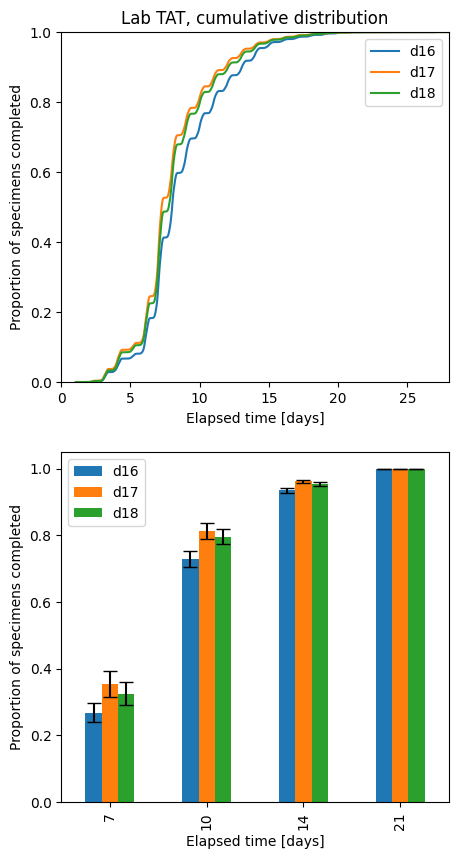

In [23]:
fig = plt.figure(figsize=(5,10))
ax1, ax2 = fig.subplots(2,1)

ax1.ecdf(lab_tat)
ax1.ecdf(lab_tat2)
ax1.ecdf(lab_tat3)
ax1.legend(labels=['d16', 'd17', 'd18'])
ax1.set_xlabel('Elapsed time [days]')
ax1.set_title('Lab TAT, cumulative distribution')
ax1.set_ylabel('Proportion of specimens completed')
ax1.set_xlim(0,28)

y_df = pd.DataFrame(
    np.array([means1, means2, means3]).T,
    index=[7,10,14,21],
    columns=['d16', 'd17', 'd18']
)
yerr_df = pd.DataFrame(
    np.array([yerr1, yerr2, yerr3]).T,
    index=[7,10,14,21],
    columns=['d16', 'd17', 'd18']
)
y_df.plot(ax=ax2, kind='bar',yerr=yerr_df, capsize=5,
          xlabel='Elapsed time [days]', ylabel='Proportion of specimens completed')